# Game Of Thrones project

### importing libraries and installing packages 

In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge imbalanced-learn

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel

### import dataset (taken from kaggle)

In [3]:
char_data = pd.read_csv('character-predictions.csv')
char_data.head(10)

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1
5,6,1,0,0.021,0.979,Tommen Baratheon,NaN,1,NaN,NaN,...,1.0,NaN,0,0,NaN,5,1,1,1.000000,1
6,7,0,0,0.014,0.986,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,...,NaN,1.0,1,1,26.0,0,0,1,0.431438,0
7,8,0,0,0.036,0.964,Viserys I Targaryen,NaN,1,NaN,NaN,...,1.0,NaN,0,0,NaN,5,1,1,0.678930,0
8,9,0,1,0.724,0.276,Wilbert,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.006689,0
9,10,1,0,0.391,0.609,Wilbert Osgrey,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.020067,1


In [4]:
# Information about the Variables
char_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

### exploratory data analysis

percentage of dead: 25.437
percentage of alive: 74.563


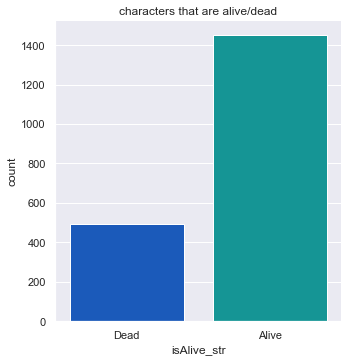

In [5]:
# exploring alive/dead characters 
isAlive_str = {0:"Dead", 1:"Alive"}
char_data["isAlive_str"] = char_data["isAlive"].map(isAlive_str)
sb.catplot(x = "isAlive_str", data = char_data, kind = "count", palette = "winter").set(title='characters that are alive/dead')
print("percentage of dead:", (((char_data['isAlive']==0).sum())*100/1946).round(3))
print("percentage of alive:",  (((char_data['isAlive']==1).sum())*100/1946).round(3))

gender distribution for ALL characters
percentage of male: 61.922
percentage of female: 38.078

gender distribution for DEAD characters
percentage of male: 74.141
percentage of female: 25.859


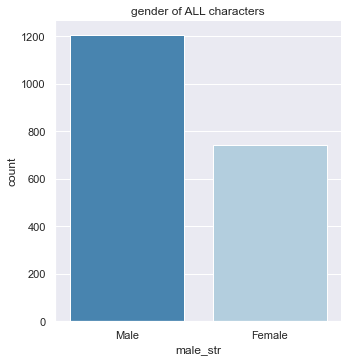

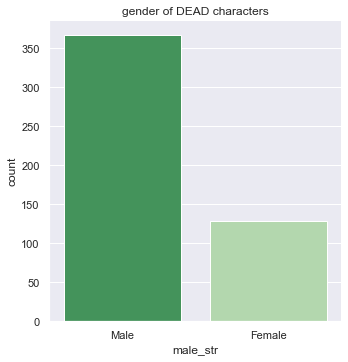

In [6]:
#explore gender of all
male_str = {0:"Female", 1:"Male"}
char_data["male_str"] = char_data["male"].map(male_str)
sb.catplot(x = "male_str", data = char_data, kind = "count", palette = "Blues_r").set(title='gender of ALL characters')
print("gender distribution for ALL characters")
print("percentage of male:", (((char_data['male_str']=="Male").sum())*100/1946).round(3))
print("percentage of female:",  (((char_data['male_str']=="Female").sum())*100/1946).round(3))
print()
#explore gender of dead 
char_data_alive = char_data[char_data.isAlive ==1]
char_data_dead = char_data[char_data.isAlive == 0]
sb.catplot(x = "male_str", data = char_data_dead, kind = "count", palette = "Greens_r").set(title='gender of DEAD characters')
print("gender distribution for DEAD characters")
print("percentage of male:", (((char_data_dead['male_str']=="Male").sum())*100/(char_data_dead['male_str']).count()).round(3))
print("percentage of female:",  (((char_data_dead['male_str']=="Female").sum())*100/(char_data_dead['male_str']).count()).round(3))

In [7]:
#exploring houses of dead/alive
char_data['house']=char_data['house'].fillna('unKnown')
char_data['houseAlive'] = char_data_alive['house'].map(char_data_alive['house'].value_counts())
char_data['houseDead'] = char_data_dead['house'].map(char_data_dead['house'].value_counts())

#as there are many houses, we take the 10 most popular houses (that most characters belong to)
housecount = char_data.groupby("house").count().sort_values(by = "name", ascending = False)[:10][['houseDead','houseAlive']].transpose().reset_index()
print(housecount) 


house       index  unKnown  Night's Watch  House Frey  House Stark  \
0       houseDead        0             45          14           22   
1      houseAlive        0             60          83           50   

house  House Targaryen  House Lannister  House Greyjoy  House Tyrell  \
0                   41               18             14             2   
1                   21               31             27            34   

house  House Martell  House Osgrey  
0                  4             5  
1                 25            16  


<AxesSubplot:title={'center':'Houses of dead vs Alive'}, xlabel='index'>

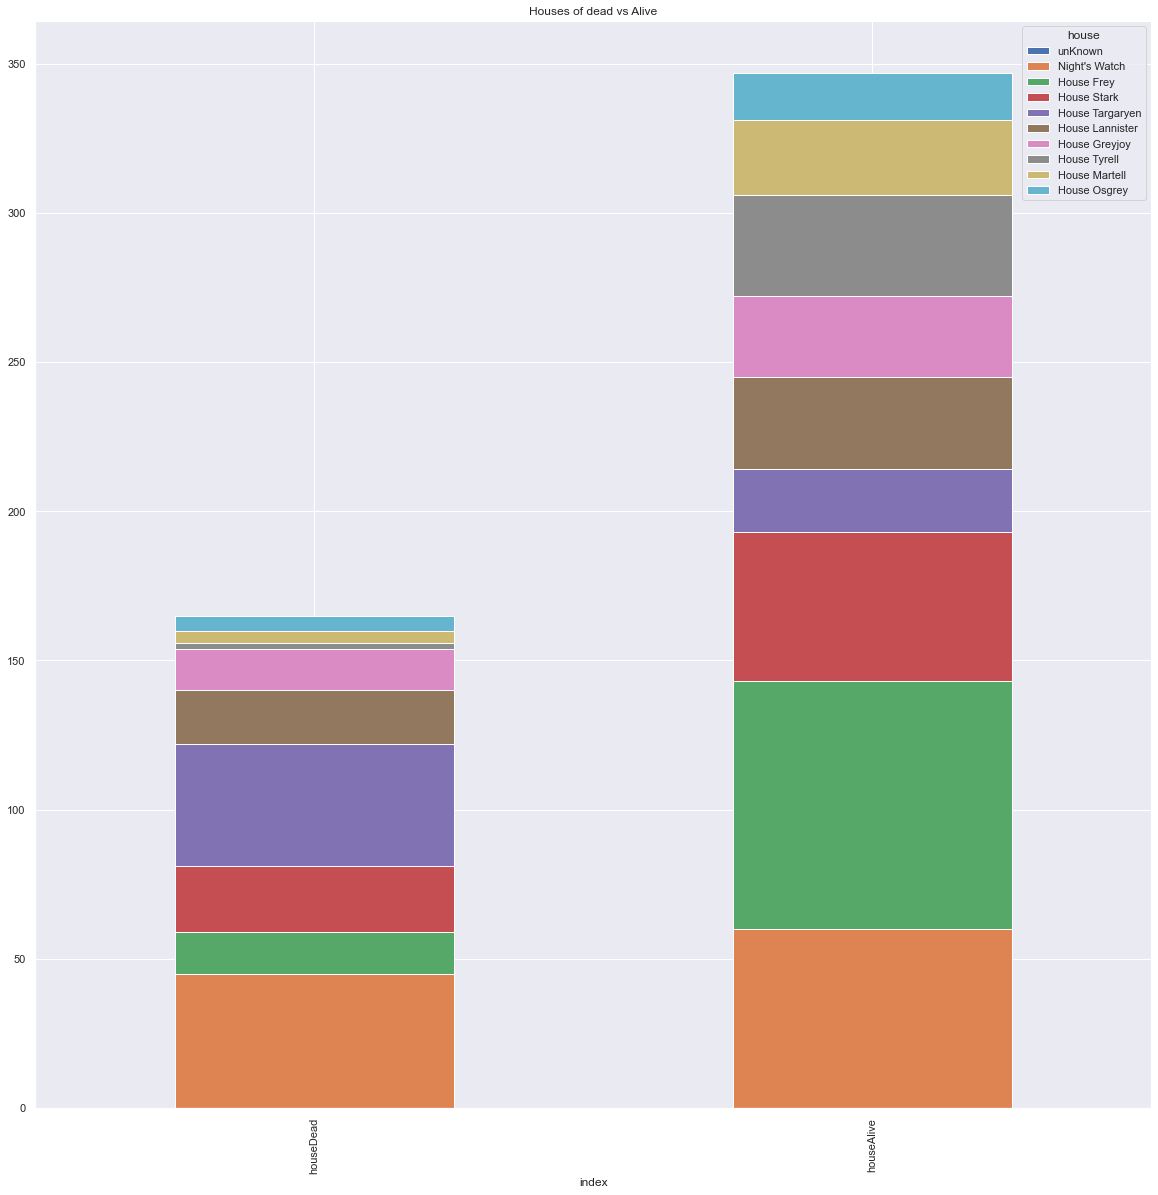

In [8]:
#plot to see houses of dead vs houses of alive 
housecount.plot.bar(x='index', stacked=True, title='Houses of dead vs Alive', figsize=(20,20))

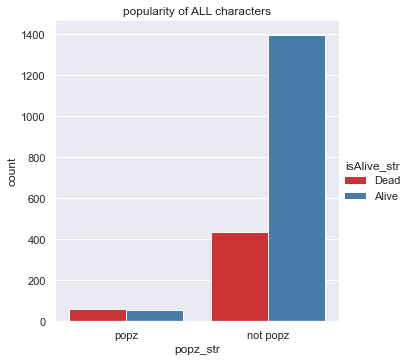

In [9]:
#explore categorical varibale for popularity 
popz_str = {0:"not popz", 1:"popz"}
char_data["popz_str"] = char_data["isPopular"].map(popz_str)
sb.catplot(x = "popz_str", data = char_data, kind = "count", hue="isAlive_str", palette= "Set1").set(title='popularity of ALL characters')

From our bar plot, it seems like majority of the characters are categorized as not popular. Hence, we explore the numerical variable for popularity instead. 

<AxesSubplot:xlabel='popularity', ylabel='isAlive_str'>

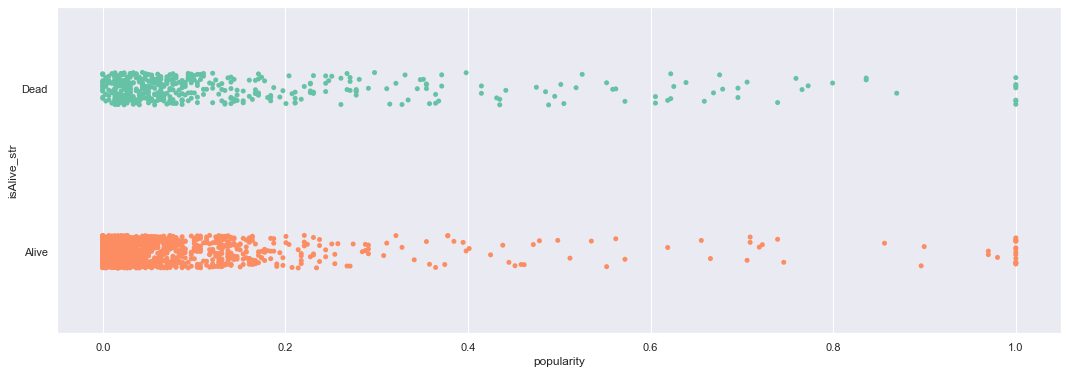

In [10]:
#explore numerical variable for popularity 
f = plt.figure(figsize=(18, 6))
sb.stripplot(x = "popularity", y = "isAlive_str", data = char_data, orient = "h", palette= "Set2")


The strip plots look rather similar. However, we are unable to tell if popularity is a good predictor purely just from the strip plot (for now).

<AxesSubplot:>

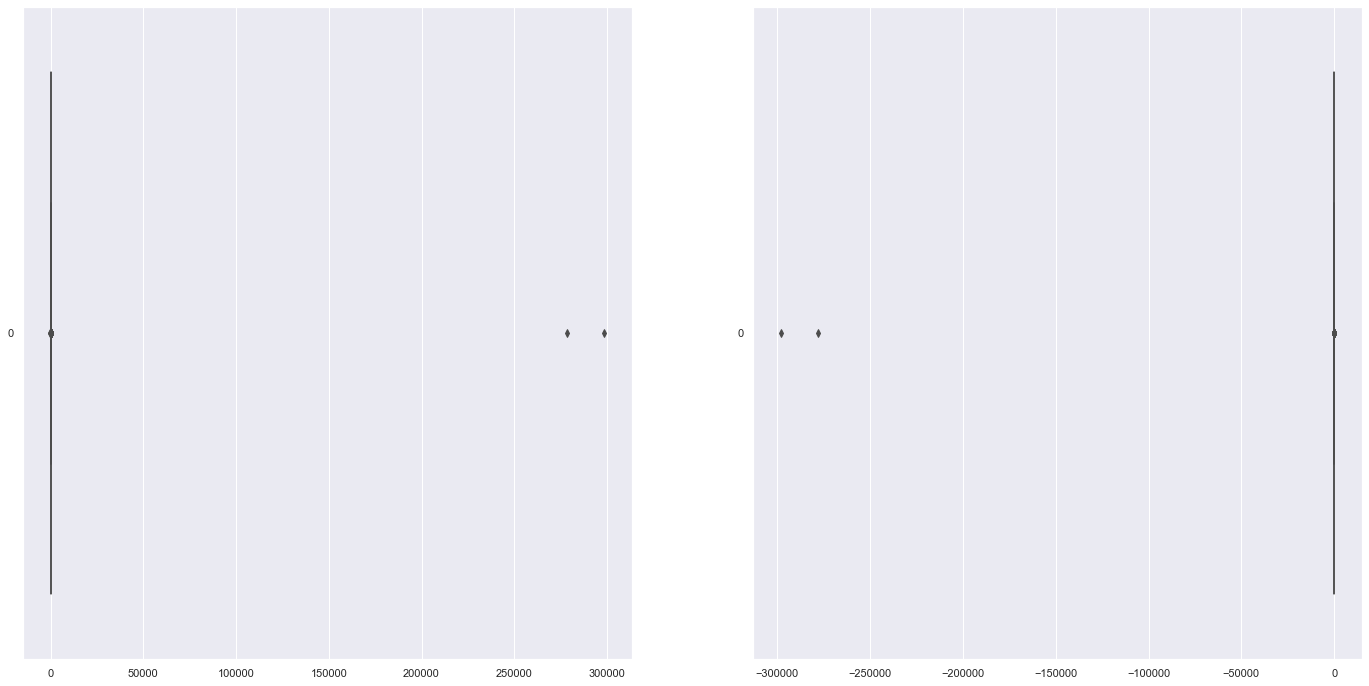

In [11]:
#explore dateofbirth and age

f, axes = plt.subplots(1,2, figsize=(24, 12))
sb.boxplot(data = char_data['dateOfBirth'], orient = "h", ax = axes[0])
sb.boxplot(data = char_data['age'], orient = "h", ax = axes[1])


For both date of birth and age variables, there are 2 distinct outliers as seen from the boxplot. Hence, we should remove these outliers as part of our cleaning process for the dataset.  

In [12]:
#to find the values of the outliers 
print(char_data['dateOfBirth'][char_data['dateOfBirth']>=250000])
print(char_data['age'][char_data['age']<=-250000])

1684    278279.0
1868    298299.0
Name: dateOfBirth, dtype: float64
1684   -277980.0
1868   -298001.0
Name: age, dtype: float64


In [13]:
#cleaning outliers
char_data['age'].values[char_data['age'] == -298001] = 0
char_data['age'].values[char_data['age'] == -277980] = 20
char_data['dateOfBirth'].values[char_data['dateOfBirth'] == 298299] = 298
char_data['dateOfBirth'].values[char_data['dateOfBirth'] == 278279] = 278


<AxesSubplot:ylabel='age'>

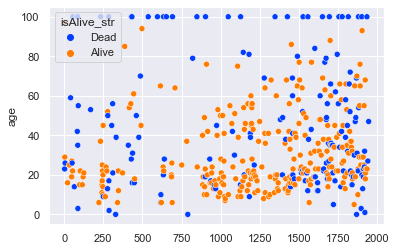

In [14]:
#age scatterplot
sb.scatterplot(x=char_data.index, y = char_data['age'], hue = char_data['isAlive_str'], palette = "bright")

<AxesSubplot:ylabel='dateOfBirth'>

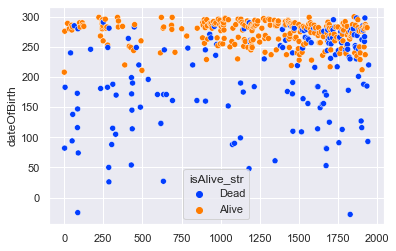

In [15]:
#date of birth scatterplot
sb.scatterplot(x=char_data.index, y = char_data['dateOfBirth'], hue = char_data['isAlive_str'], palette = "bright")

After removing the outliers, it seems that characters with a more recent date of birth, and hence lower age are mostly still alive. 

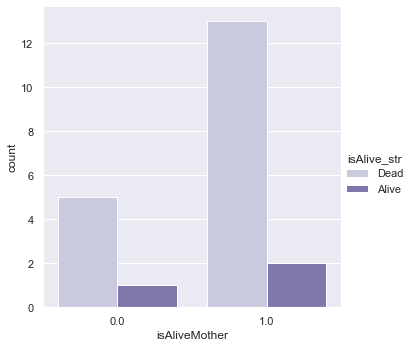

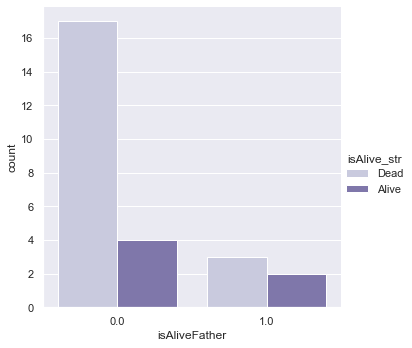

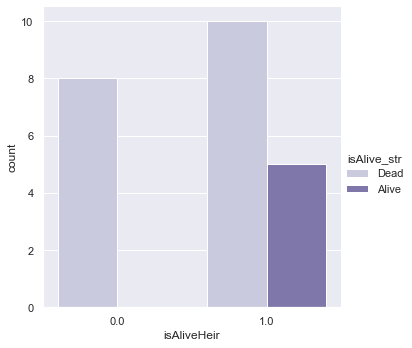

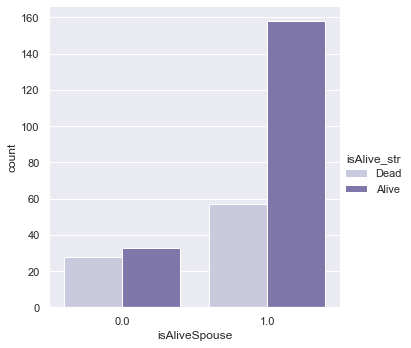

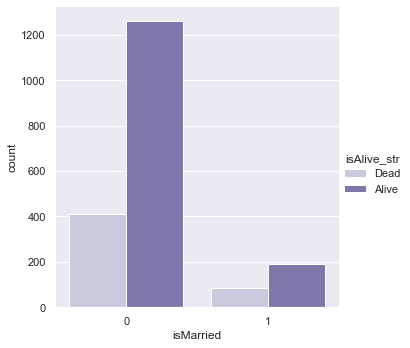

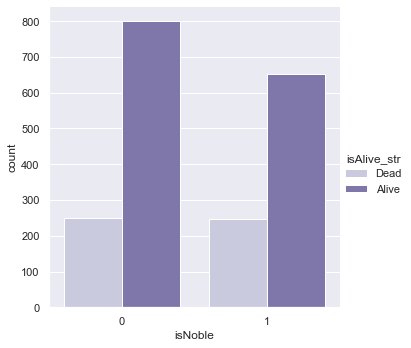

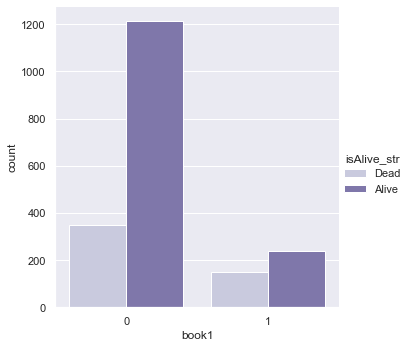

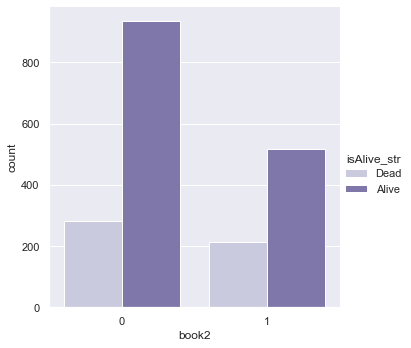

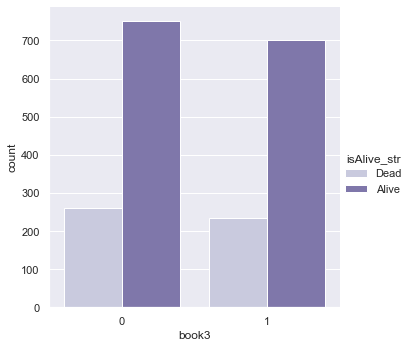

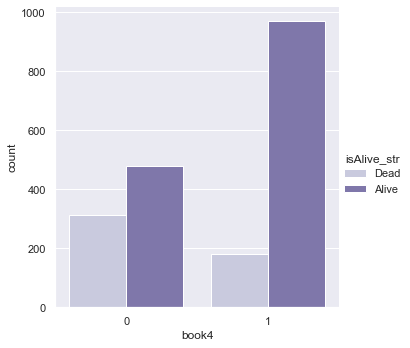

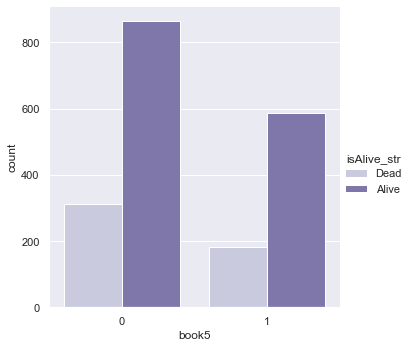

In [16]:
#now we explore other variables 
names=['isAliveMother','isAliveFather','isAliveHeir','isAliveSpouse', 'isMarried', 'isNoble', 'book1', 'book2', 'book3', 'book4', 'book5']
for var in names:
    sb.catplot(x = var, data = char_data, kind = "count", hue="isAlive_str", palette= "Purples")

### cleaning dataset
##### choosing variables for prediction

In [17]:
char_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1946 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

Our first criteria is to select the variables that contain the least number of null values. 
We hence select the variables with zero missing values first. 
We have also selected dateOfBirth and age although they only have 433 filled values. 

Although certain variables such as house and culture have little missing values, they are not selected as they have too many categorical unique values as seen. 



In [18]:
print("Types of Unique Houses :", len(char_data["house"].unique()))
print("Types of Unique Cultures :", len(char_data["culture"].unique()))

Types of Unique Houses : 348
Types of Unique Cultures : 65


To further condense the data set, we combine the 5 book variables to a single variable totalBooksIn. 
Then, we make a new data set char_data_clean containing our selected variables. 

In [19]:
char_data['totalBooksIn']=char_data[['book1','book2','book3','book4','book5']].sum(axis=1)
char_data_clean=pd.DataFrame(char_data[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity', 'isAlive']])

Although date of birth and age are now outlier-free, but there are several characters with missing ages and birthdays as seen from how both variables only have 433 non-null values 
Let’s impute both with their medians.

In [20]:
dob_median = char_data_clean['dateOfBirth'].median()
char_data_clean['dateOfBirth'] = char_data_clean['dateOfBirth'].fillna(dob_median).round(3)
age_median = char_data_clean['age'].median()
char_data_clean['age'] = char_data_clean['age'].fillna(age_median).round(3)


Here is what our cleaned data set looks like. 

In [21]:
char_data_clean.head(10)

,dateOfBirth,age,male,isMarried,isNoble,totalBooksIn,numDeadRelations,popularity,isAlive
0,268.0,27.0,1,0,0,0,11,0.605351,0
1,208.0,97.0,1,1,1,5,1,0.896321,1
2,268.0,27.0,1,0,1,1,0,0.267559,1
3,82.0,23.0,0,1,1,0,0,0.183946,0
4,276.0,29.0,0,1,1,1,0,0.043478,1
5,268.0,27.0,1,0,0,0,5,1.000000,1
6,183.0,26.0,1,1,1,0,0,0.431438,0
7,268.0,27.0,1,0,0,0,5,0.678930,0
8,268.0,27.0,1,0,1,1,0,0.006689,0
9,268.0,27.0,1,0,1,0,0,0.020067,1


### Resampling using SMOTE-NC 
Synthetic Minority Over-sampling TEchnique-Nominal Continuous (SMOTE-NC) algorithm looks into minority class instances and use k nearest neighbor to select a random nearest neighbor, and a synthetic instance is created randomly in feature space. 

Text(0.5, 0, 'After SMOTENC oversampling')

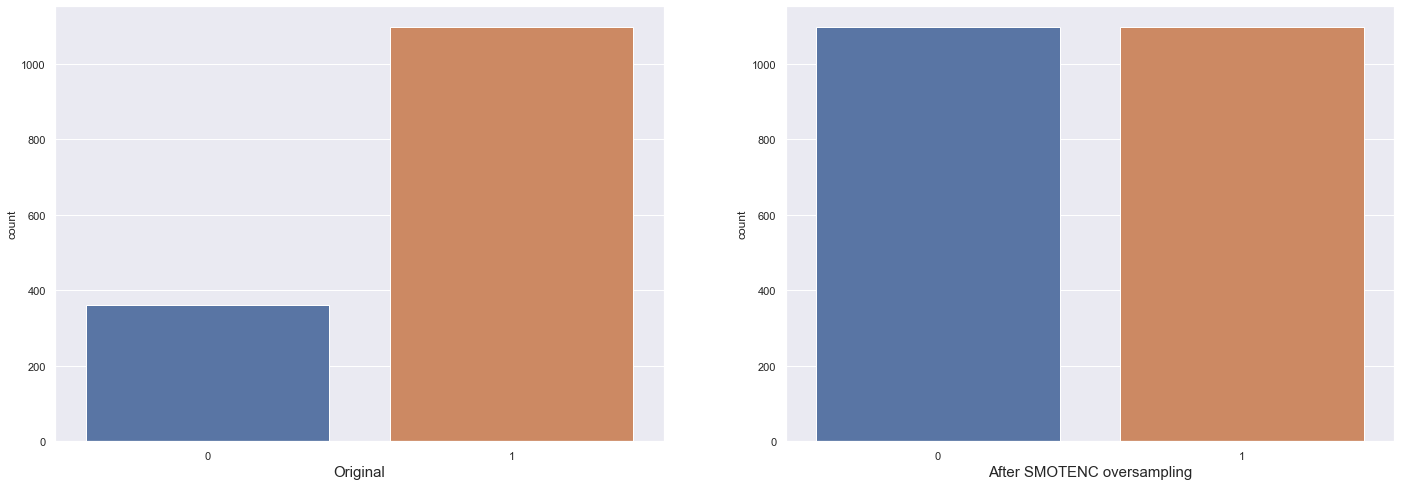

In [22]:
from imblearn.over_sampling import SMOTENC

#original train set 
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','numDeadRelations','totalBooksIn', 'popularity']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=500)

#concat into train_df
train_df = pd.concat([X_train, y_train], axis=1)

#using SMOTENC to resample
#we pinpoint the categorical variables through indexing
smotenc = SMOTENC([2,3,4,5],random_state = 101)
X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)

#concat into oversampled_train_df
oversampled_train_df = pd.concat([X_oversample, y_oversample], axis=1)
oversampled_train_df.head()

#now we use plots to visualise the distribution of classes in our dataset 
fig, axes =plt.subplots(1,2,figsize=(24,8))
sb.countplot(x=train_df['isAlive'], ax=axes[0])
ax = axes[0]
ax.set_xlabel("Original",fontsize=15)
sb.countplot(x=oversampled_train_df['isAlive'], ax=axes[1])
ax = axes[1]
ax.set_xlabel("After SMOTENC oversampling",fontsize=15)



SMOTENC returns us a more balanced dataset as shown, through oversampling the minority class “dead”. 


# Decision Tree Classifier
### decision tree classifier on original train set

TRAIN Dataset
Classification Accuracy: 	 0.8279643591501028
AUC score: 	 0.84807763010118
F1-score: 	 0.8944934846574191

TEST Dataset
Classification Accuracy 	: 0.7741273100616016
AUC score	: 0.7480353425937726
F1-score: 	 0.8571428571428572
(array([0.        , 0.64661654, 1.        ]), array([0.        , 0.93220339, 1.        ]), array([2, 1, 0], dtype=int64))


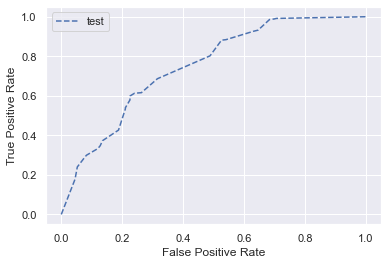

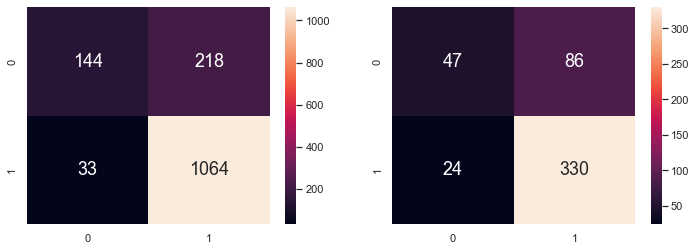

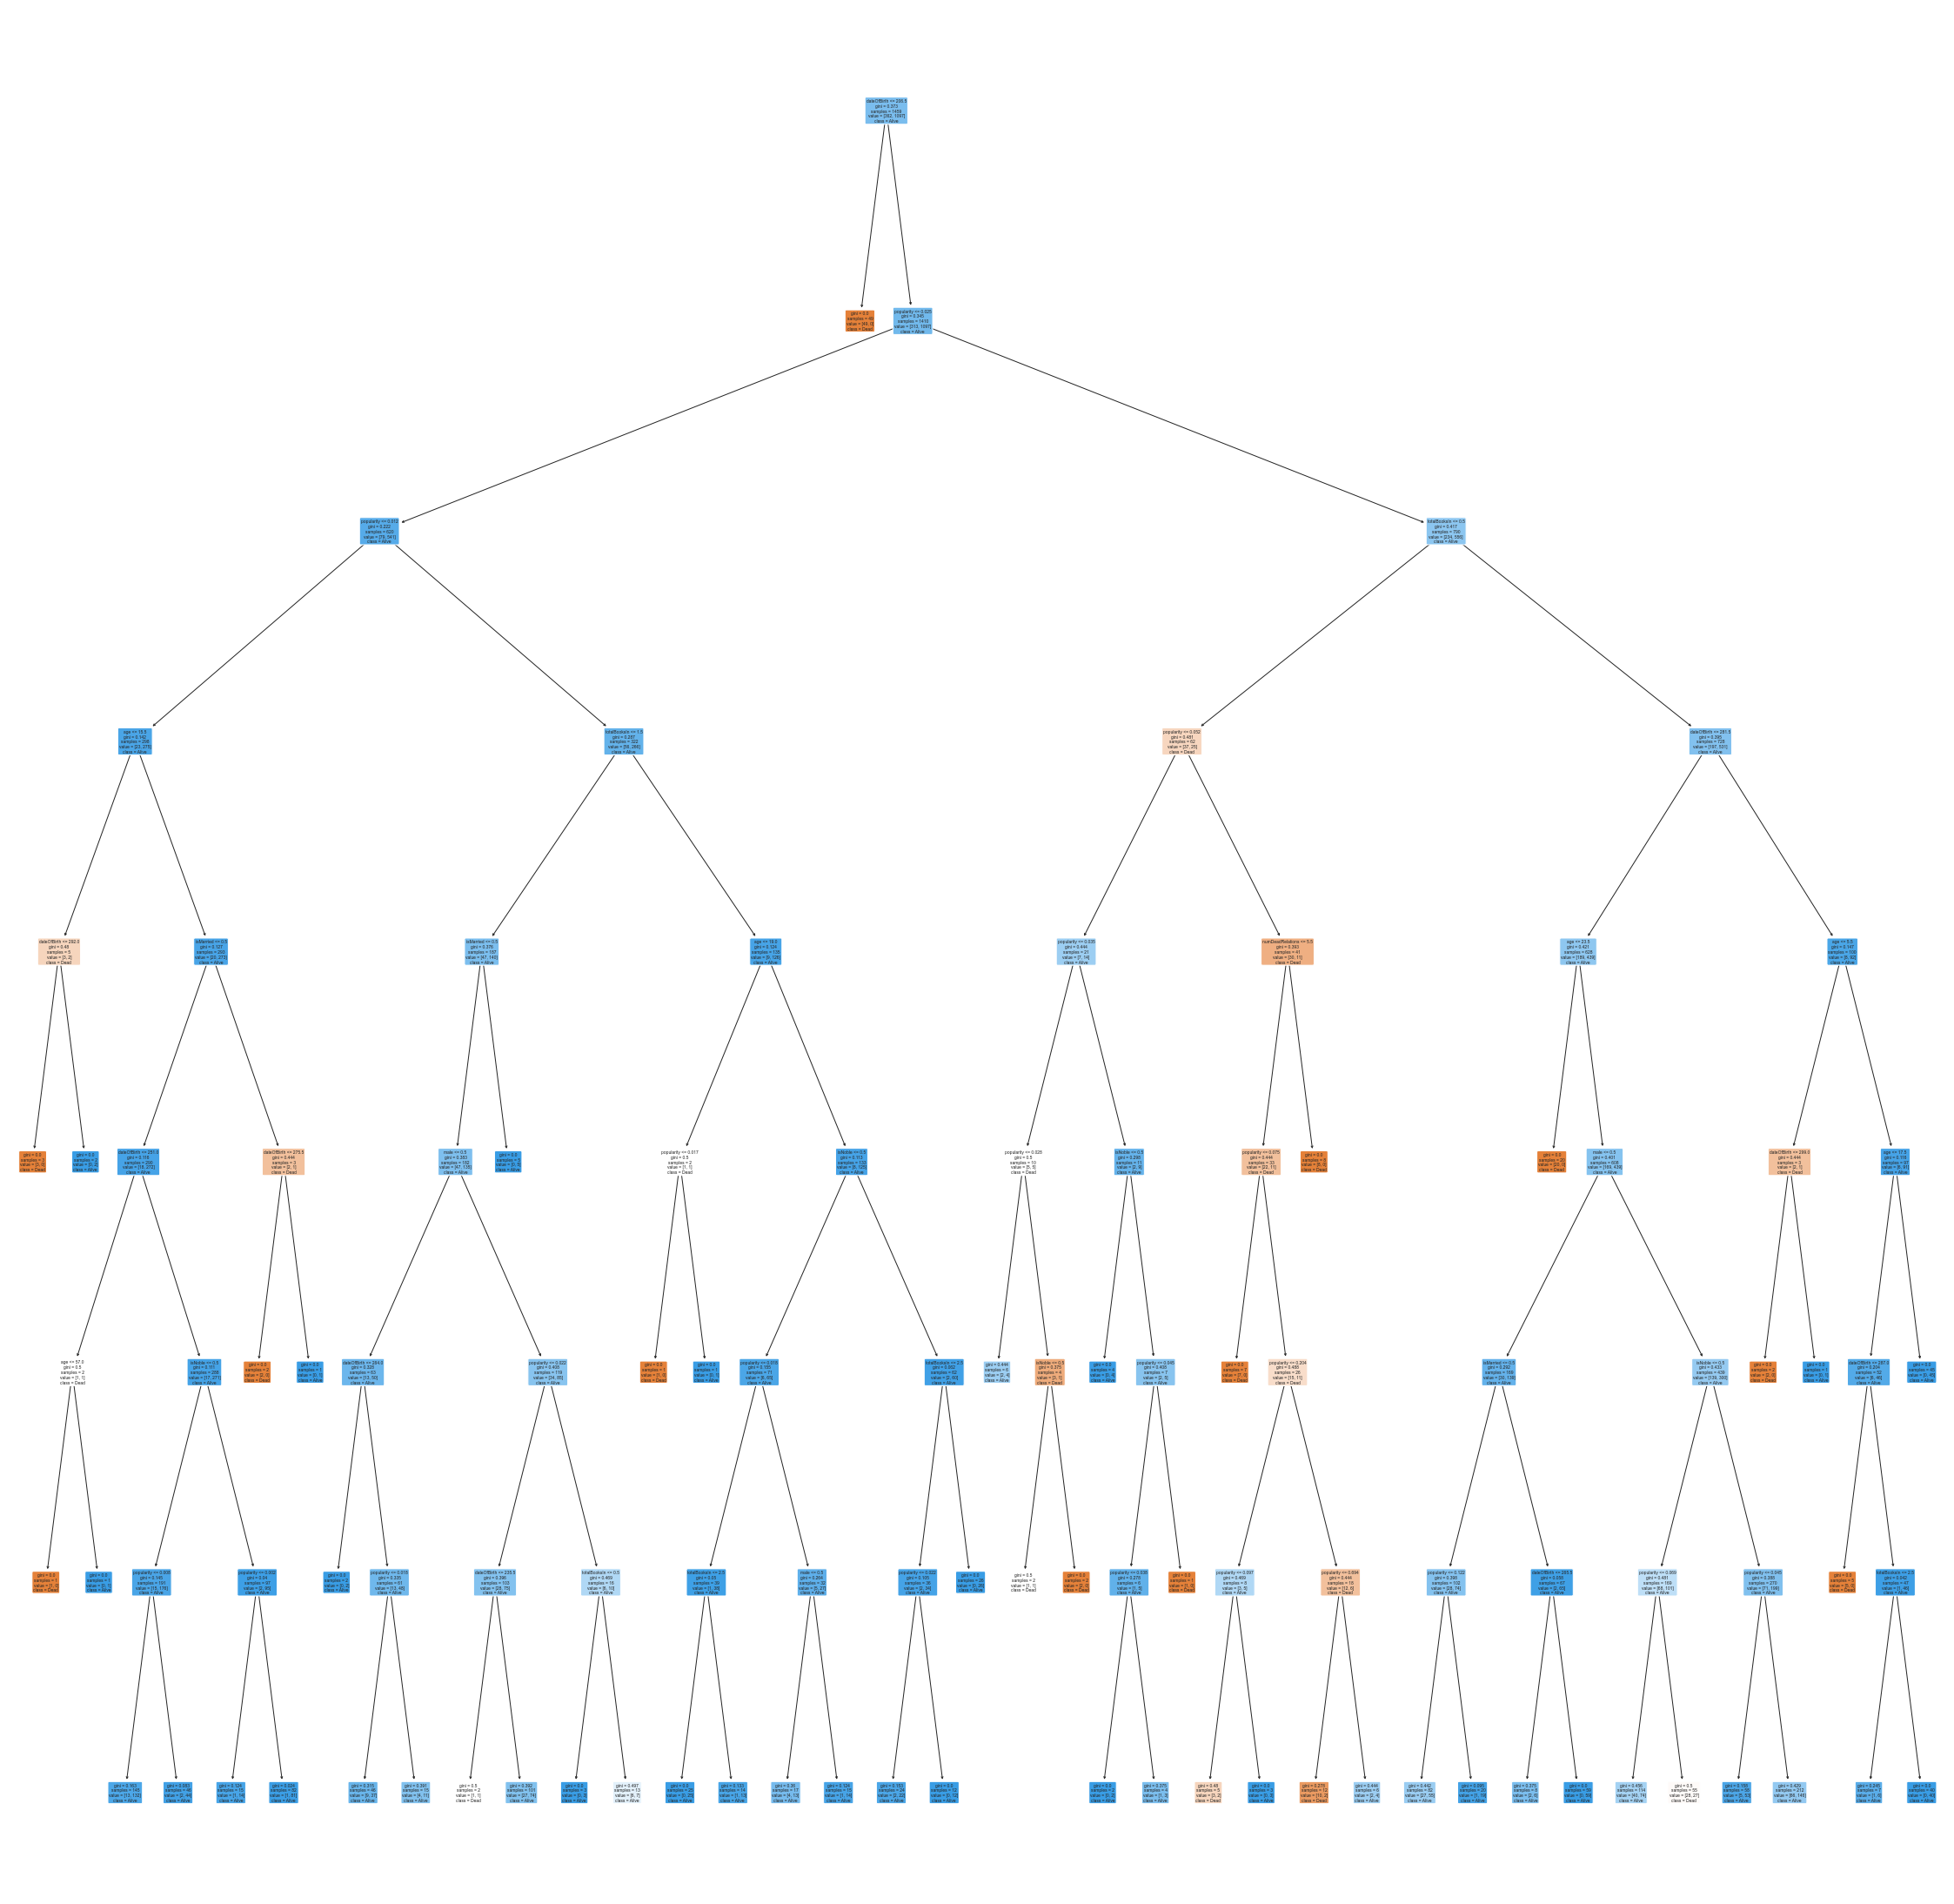

In [23]:
from sklearn.tree import plot_tree

def classification(X,y):
# Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=500)
    
    dectree = DecisionTreeClassifier(max_depth = 8) 
    dectree.fit(X_train, y_train)   
    
    # Predict Response corresponding to Predictors
    y_train_pred = dectree.predict(X_train)
    # we have to use #classiferofchoice#.predict_proba() so as to evaluate the ROC AUC score later on
    y_train_proba = dectree.predict_proba(X_train)
    y_test_pred = dectree.predict(X_test)
    y_test_proba = dectree.predict_proba(X_test)
    
    cm_train=confusion_matrix(y_train, y_train_pred)
    cm_test=confusion_matrix(y_test, y_test_pred)

    # Check the Goodness of Fit (on Train Data)
    print("TRAIN Dataset")
    print("Classification Accuracy: \t", dectree.score(X_train, y_train))
    print("AUC score: \t", roc_auc_score(y_train, y_train_proba[:,1]))
    print("F1-score: \t", f1_score(y_train, y_train_pred))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("TEST Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print("AUC score\t:", roc_auc_score(y_test, y_test_proba[:,1]))
    print("F1-score: \t", f1_score(y_test, y_test_pred))
    print(roc_curve(y_test, y_test_pred))
    fpr, tpr, z = roc_curve(y_test, y_test_proba[:,1])
    
    
    # plot the roc curve for the TEST model
    plt.plot(fpr, tpr, linestyle='--', label='test')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap((cm_train),
        annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap((cm_test), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


    f = plt.figure(figsize=(40,40))
    plot_tree(dectree, filled=True, rounded=True, 
              feature_names=X_train.columns, 
              class_names=["Dead","Alive"])
    
    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test=classification(pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']]),pd.DataFrame(char_data_clean["isAlive"]))

Upon close inspection of the decision tree, it seems that popularity and dateOfBirth are good predictors. For popularity, it seems that higher popularity is positive related to death.  

### Decision tree on resampled train set

In [24]:
dectree = DecisionTreeClassifier(max_depth = 8) 
dectree.fit(X_oversample, y_oversample)
y_oversample_pred = dectree.predict(X_test)
y_oversample_proba = dectree.predict_proba(X_test)
print("TEST Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print("AUC score\t:", roc_auc_score(y_test, y_oversample_proba[:,1]))
print("F1-score: \t", f1_score(y_test, y_oversample_pred))

TEST Dataset
Classification Accuracy 	: 0.6447638603696099
AUC score	: 0.7325410985089844
F1-score: 	 0.715927750410509


# Cost Complexity Pruning (CCP)
CCP is used to decrease overfitting by reducing the size of the Decision Tree, hence reducing complexity and improving predictive accuracy. 

### CCP on original train set

In [25]:
dectree = DecisionTreeClassifier(max_depth = 8) 

path = dectree.cost_complexity_pruning_path(X_train, y_train)
alphas=path['ccp_alphas']

alphas

array([0.00000000e+00, 5.15759770e-05, 6.27656556e-05, 7.00140765e-05,
       7.81966122e-05, 1.02074423e-04, 1.14233493e-04, 1.20564936e-04,
       1.45539817e-04, 1.66662847e-04, 2.81835634e-04, 2.95785281e-04,
       3.42700480e-04, 4.23147498e-04, 4.44864171e-04, 5.50397740e-04,
       5.71167466e-04, 6.03562039e-04, 6.03977387e-04, 6.07423470e-04,
       7.26940412e-04, 9.13867946e-04, 9.13867946e-04, 9.25291295e-04,
       1.00833026e-03, 1.16698193e-03, 1.27304514e-03, 1.48785058e-03,
       1.64496230e-03, 1.71894365e-03, 1.90544199e-03, 2.61119942e-03,
       2.82513569e-03, 2.96625190e-03, 3.02112088e-03, 3.27761246e-03,
       9.31440791e-03, 1.35654025e-02, 3.92924975e-02])

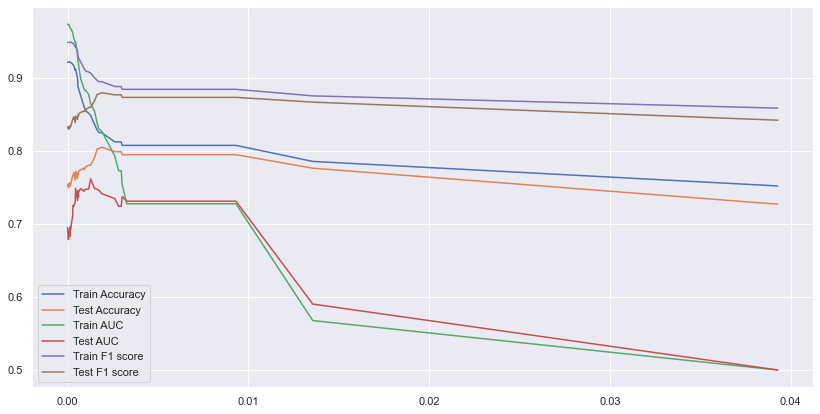

In [26]:
accuracy_train,accuracy_test,auc_train, auc_test, f1_train, f1_test=[],[],[],[],[],[]


for i in alphas :
        dectree=DecisionTreeClassifier(ccp_alpha=i)
        
        dectree.fit(X_train, y_train)
        y_train_pred=dectree.predict(X_train)
        y_test_pred=dectree.predict(X_test)
        y_test_proba = dectree.predict_proba(X_test)
        y_train_proba = dectree.predict_proba(X_train)
      
        
        accuracy_train.append(accuracy_score(y_train,y_train_pred))
        accuracy_test.append(accuracy_score(y_test,y_test_pred))
        auc_train.append(roc_auc_score(y_train,y_train_proba[:,1]))
        auc_test.append(roc_auc_score(y_test,y_test_proba[:,1]))
        f1_train.append(f1_score(y_train,y_train_pred))
        f1_test.append(f1_score(y_test,y_test_pred))
    

sb.set()
plt.figure(figsize= (14,7))
sb.lineplot(y=accuracy_train,x=alphas, label="Train Accuracy")
sb.lineplot(y=accuracy_test,x=alphas,label="Test Accuracy")
sb.lineplot(y=auc_train,x=alphas, label="Train AUC")
sb.lineplot(y=auc_test,x=alphas,label="Test AUC")
sb.lineplot(y=f1_train,x=alphas, label="Train F1 score")
sb.lineplot(y=f1_test,x=alphas,label="Test F1 score")
plt.xticks(ticks=np.arange(0.00, 0.05, 0.01))
plt.show()

In [27]:
#reduce overfitting
print("Results of Cost Complexity Pruning(CCP)")
print("TEST set(using original train set)")
print("maximum accuracy:", max(accuracy_test))
print("maximum AUC:", max(auc_test))
print("maximum F1 score:", max(f1_test))


Results of Cost Complexity Pruning(CCP)
TEST set(using original train set)
maximum accuracy: 0.8049281314168378
maximum AUC: 0.7616498874304405
maximum F1 score: 0.8792884371029225


### CCP on resampled train set

In [28]:
dectree = DecisionTreeClassifier(max_depth = 8) 

path = dectree.cost_complexity_pruning_path(X_oversample, y_oversample)
alphas=path['ccp_alphas']

alphas

array([0.00000000e+00, 8.69548835e-06, 1.92813002e-05, 2.77813951e-05,
       3.12898293e-05, 8.18081948e-05, 4.29200851e-04, 4.48063285e-04,
       5.81539396e-04, 6.07718019e-04, 6.80267772e-04, 6.94534879e-04,
       7.14896471e-04, 7.29261623e-04, 7.29261623e-04, 7.97629900e-04,
       8.02632457e-04, 8.20846749e-04, 8.76516373e-04, 9.23963312e-04,
       1.02138079e-03, 1.11652489e-03, 1.11668186e-03, 1.31794269e-03,
       1.40347578e-03, 1.72647164e-03, 1.84963082e-03, 2.10237585e-03,
       2.28259272e-03, 2.47382103e-03, 2.54578603e-03, 2.56765333e-03,
       2.67395928e-03, 5.02983086e-03, 5.37698917e-03, 5.72175488e-03,
       9.33216313e-03, 9.43513603e-03, 1.08990699e-02, 1.09634268e-02,
       1.54597205e-02, 2.04856445e-02, 4.62801596e-02])

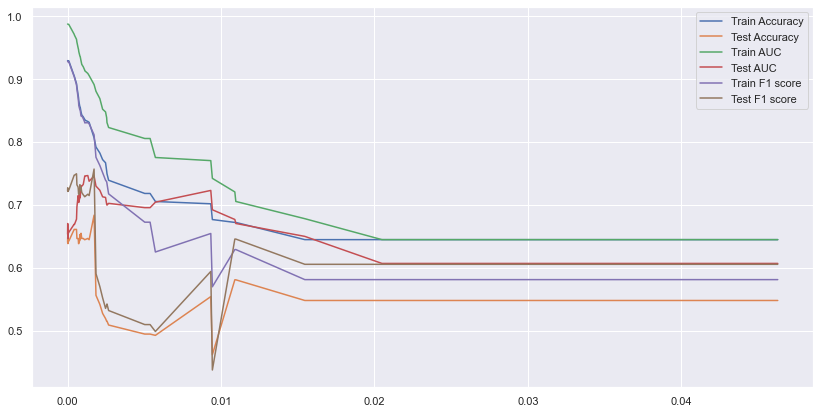

In [29]:
accuracy_oversample_train,accuracy_oversample_test,auc_oversample_train, auc_oversample_test, f1_oversample_train, f1_oversample_test=[],[],[],[],[],[]


for i in alphas :
        dectree=DecisionTreeClassifier(ccp_alpha=i)
        
        dectree.fit(X_oversample, y_oversample)
        y_oversample_pred=dectree.predict(X_oversample)
        y_test_pred=dectree.predict(X_test)
        y_test_proba = dectree.predict_proba(X_test)
        y_oversample_proba = dectree.predict_proba(X_oversample)
        
        accuracy_oversample_train.append(accuracy_score(y_oversample,y_oversample_pred))
        accuracy_oversample_test.append(accuracy_score(y_test,y_test_pred))
        auc_oversample_train.append(roc_auc_score(y_oversample, y_oversample_proba[:,1]))
        auc_oversample_test.append(roc_auc_score(y_test,y_test_proba[:,1]))
        f1_oversample_train.append(f1_score(y_oversample,y_oversample_pred))
        f1_oversample_test.append(f1_score(y_test,y_test_pred))
    

sb.set()
plt.figure(figsize= (14,7))
sb.lineplot(y=accuracy_oversample_train,x=alphas, label="Train Accuracy")
sb.lineplot(y=accuracy_oversample_test,x=alphas,label="Test Accuracy")
sb.lineplot(y=auc_oversample_train,x=alphas, label="Train AUC")
sb.lineplot(y=auc_oversample_test,x=alphas,label="Test AUC")
sb.lineplot(y=f1_oversample_train,x=alphas, label="Train F1 score")
sb.lineplot(y=f1_oversample_test,x=alphas,label="Test F1 score")
plt.xticks(ticks=np.arange(0.00, 0.05, 0.01))
plt.show()

In [30]:
print("Results of Cost Complexity Pruning(CCP)")
print("TEST set(using resampled train set)")
print("maximum accuracy:", max(accuracy_oversample_test))
print("maximum AUC:", max(auc_oversample_test))
print("maximum F1 score:", max(f1_oversample_test))


Results of Cost Complexity Pruning(CCP)
TEST set(using resampled train set)
maximum accuracy: 0.6837782340862423
maximum AUC: 0.7467928295314558
maximum F1 score: 0.7570977917981072


# Feature selection on Random Forest
Used to identify more important variables through Gini Impurity (the more a variable decreases the impurity, the more important it is)
Increases interpretability and predictive accuracy

### Random forest (with full features) on original train set

In [40]:
forest = RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     max_depth = 8,
                                     min_samples_leaf = 4,
                                     bootstrap = True,
                                     warm_start = False,
                                    )
#train the classifier
forest.fit(X_train, y_train.values.ravel())

# Create a selector object that will use the random forest classifier to identify most important features 
sfm= SelectFromModel(forest, threshold = 0.15)

# Train the selector
sfm.fit(X_train, y_train.values.ravel())
sfm.get_support()
selected_feat= X_train.columns[(sfm.get_support())]
print(selected_feat)



Index(['dateOfBirth', 'popularity'], dtype='object')


In [41]:

y_test_pred = forest.predict(X_test)
y_test_proba = forest.predict_proba(X_test)
# View The Accuracy Of Our Full Feature Model

print("TEST Dataset (Full feature random forest on orginal train set)")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print("AUC score\t:", roc_auc_score(y_test, y_test_proba[:,1]))
print("F1-score: \t", f1_score(y_test, y_test_pred))


TEST Dataset (Full feature random forest on orginal train set)
Classification Accuracy 	: 0.7987679671457906
AUC score	: 0.7749670787137335
F1-score: 	 0.8768844221105526


### Random forest (with selected features) on original train set

In [42]:

# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
forest_important = RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     max_depth = 8,
                                     min_samples_leaf = 4,
                                     bootstrap = True,
                                     warm_start = False,
                                     )

# Train the new classifier on the new dataset containing the most important features
forest_important.fit(X_important_train, y_train.values.ravel())


y_test_pred = forest_important.predict(X_important_test)
y_test_proba = forest_important.predict_proba(X_important_test)
# View The Accuracy Of Our Selected Feature(s) Model

print("TEST Dataset (Selected feature random forest on orginal train set)")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print("AUC score\t:", roc_auc_score(y_test, y_test_proba[:,1]))
print("F1-score: \t", f1_score(y_test, y_test_pred))


TEST Dataset (Selected feature random forest on orginal train set)
Classification Accuracy 	: 0.7802874743326489
AUC score	: 0.745199864066947
F1-score: 	 0.8657465495608533


The accuracy, AUC score and F1-score has dropped slightly, but this is a small cost in exchange of reducing our features from 8 to 2. Let's try the random forest with selected features on our resampled train set as well. 

### Random forest (with full features) on resampled train set

In [43]:
forest2 = RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     max_depth = 8,
                                     min_samples_leaf = 4,
                                     bootstrap = True,
                                     warm_start = False,
                                    )
#train the classifier
forest2.fit(X_train, y_train.values.ravel())

# Create a selector object that will use the random forest classifier to identify most important features 
sfm2 = SelectFromModel(forest2, threshold = 0.15)

# Train the selector
sfm2.fit(X_oversample, y_oversample.values.ravel())
sfm2.get_support()
selected_feat= X_oversample.columns[(sfm.get_support())]
print(selected_feat)


Index(['dateOfBirth', 'popularity'], dtype='object')


We get the same 2 most important features as that of the original train set! Now let's look at accuracy.

In [44]:
y_test_pred = forest2.predict(X_test)
y_test_proba = forest2.predict_proba(X_test)
# View The Accuracy Of Our Full Feature Model

print("TEST Dataset (Full feature random forest on resampled train set)")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print("AUC score\t:", roc_auc_score(y_test, y_test_proba[:,1]))
print("F1-score: \t", f1_score(y_test, y_test_pred))


TEST Dataset (Full feature random forest on resampled train set)
Classification Accuracy 	: 0.7967145790554415
AUC score	: 0.7784716027356527
F1-score: 	 0.8754716981132076


### Random forest (with selected features) on original train set

In [45]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important2_train = sfm2.transform(X_oversample)
X_important2_test = sfm2.transform(X_test)

# Create a new random forest classifier for the most important features
forest_important2 = RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     max_depth = 8,
                                     min_samples_leaf = 4,
                                     bootstrap = True,
                                     warm_start = False,
                                     )

# Train the new classifier on the new dataset containing the most important features
forest_important2.fit(X_important2_train, y_oversample.values.ravel())


y_test_pred = forest_important2.predict(X_important2_test)
y_test_proba = forest_important2.predict_proba(X_important2_test)
# View The Accuracy Of Our Selected Feature(s) Model

print("TEST Dataset (Selected feature random forest on resampled train set)")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print("AUC score\t:", roc_auc_score(y_test, y_test_proba[:,1]))
print("F1-score: \t", f1_score(y_test, y_test_pred))


TEST Dataset (Selected feature random forest on resampled train set)
Classification Accuracy 	: 0.648870636550308
AUC score	: 0.7245019327980969
F1-score: 	 0.7237479806138934


The accuracy, AUC score and F1-score drop by a larger amount. As compared to the the selected features model on the original train set, there is quite a high cost involved for the resampled train set in exchange for less features. 

# XGBoost
XGBoost uses a gradient boosting framework to improve model performance through optimized hyper-parameter tuning.
### XGBoost on original train set

TEST Dataset (XGBoost on orginal train set)
Classification Accuracy 	: 0.8090349075975359
AUC score	: 0.794836667941039
F1-score: 	 0.8777923784494088


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

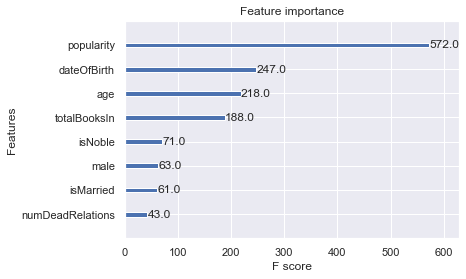

In [35]:
xgb_cl1 = xgb.XGBClassifier()

xgb_cl1.fit(X_train, y_train)

y_test_pred = xgb_cl1.predict(X_test)
y_test_proba = xgb_cl1.predict_proba(X_test)

print("TEST Dataset (XGBoost on orginal train set)")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print("AUC score\t:", roc_auc_score(y_test, y_test_proba[:,1]))
print("F1-score: \t", f1_score(y_test, y_test_pred))

#plot feature importance
xgb.plot_importance(xgb_cl1)

### XGBoost on resampled train set

TEST Dataset (XGBoost on resampled train set)
Classification Accuracy 	: 0.6078028747433265
AUC score	: 0.7436918567605455
F1-score: 	 0.6779089376053963


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

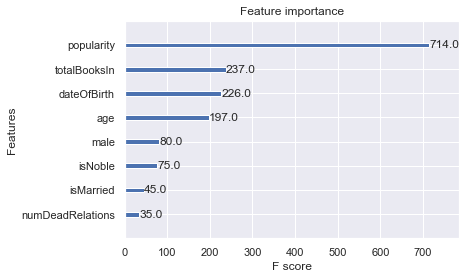

In [36]:

xgb_cl2 = xgb.XGBClassifier()

xgb_cl2.fit(X_oversample, y_oversample)


y_oversample_pred = xgb_cl2.predict(X_test)
y_oversample_proba = xgb_cl2.predict_proba(X_test)
print("TEST Dataset (XGBoost on resampled train set)")
print("Classification Accuracy \t:", accuracy_score(y_test, y_oversample_pred))
print("AUC score\t:", roc_auc_score(y_test, y_oversample_proba[:,1]))
print("F1-score: \t", f1_score(y_test, y_oversample_pred))

#plot feature importance
xgb.plot_importance(xgb_cl2)

# XGBoost with GridSearchCV
GridSearch is an optimizatoin algorithm to find the best hyperparameters.
As the time complexity of GridSearchCV is very high, we have used HalvingGridSearchCV instead.

#### To find hyperparameters for highest accuracy

In [37]:
from sklearn.model_selection import GridSearchCV
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])
params = { 'max_depth': [3, 6, 8],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20)
gridSearch_xgb = HalvingGridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='accuracy', 
                   verbose=1)
gridSearch_xgb.fit(X, y)
print("Best parameters:", gridSearch_xgb.best_params_)
print("Highest accuracy: ", gridSearch_xgb.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 72
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 216
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 648
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 1944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Highest accuracy:  0.7846182386770201


#### To find hyperparameters for best AUC

In [38]:
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])
params = { 'max_depth': [3, 6, 8],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20)
clf = HalvingGridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring="roc_auc", 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Highest AUC: ", clf.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 72
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 216
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 648
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 1944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Highest AUC:  0.7938967401688959


#### To find hyperparameters for best F1 score

In [39]:
y = pd.DataFrame(char_data_clean["isAlive"])
X = pd.DataFrame(char_data_clean[['dateOfBirth', 'age', 'male', 'isMarried', 'isNoble','totalBooksIn','numDeadRelations', 'popularity']])
params = { 'max_depth': [3, 6, 8],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20)
clf = HalvingGridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring="f1", 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Highest F1 score: ", clf.best_score_)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 72
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 216
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 648
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 1944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Highest F1 score:  0.8693779069116798


# LightGBM 
Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm. It splits the tree leaf wise with the best fit. When growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

### LightGBM (with orginal train set)

In [40]:
from lightgbm import LGBMClassifier

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 70,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': 1
             }

model_lgb = lgb.train(parameters,
                            train_data,
                            valid_sets=test_data,
                            num_boost_round=5000,
                            early_stopping_rounds=50)

[LightGBM] [Info] Number of positive: 1097, number of negative: 362
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.751885 -> initscore=1.108690
[LightGBM] [Info] Start training from score 1.108690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.735185
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.7344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.74538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	v

C:\Users\denis\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [41]:

y_train_pred = model_lgb.predict(X_train)
y_test_pred = model_lgb.predict(X_test)

print("Results from LightGBM:")
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))


Results from LightGBM:
AUC Train: 0.7798
AUC Test: 0.7875


### Light GBM (with oversampled train set)

In [42]:

train2_data = lgb.Dataset(X_oversample, label=y_oversample)
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 70,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': 1
             }

model_lgb = lgb.train(parameters,
                            train2_data,
                            valid_sets=test_data,
                            num_boost_round=5000,
                            early_stopping_rounds=50)





[LightGBM] [Info] Number of positive: 1097, number of negative: 1097
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 2194, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.663842
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.6806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.674685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 0.657842
[LightGBM] [Warning] No furt

C:\Users\denis\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [43]:

y_train2_pred = model_lgb.predict(X_oversample)
y_test_pred = model_lgb.predict(X_test)

print("Results from LightGBM:")
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_oversample, y_train2_pred),
                                                    roc_auc_score(y_test, y_test_pred)))


Results from LightGBM:
AUC Train: 0.8230
AUC Test: 0.7291
